Test selecting road points and bounding bounding boxes of roads 

In [34]:
%matplotlib inline

import collections
import math
import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import dill
import scipy
import scipy.ndimage
import scipy.interpolate
import shapely
import shapely.geometry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import cv2 as cv

import carla
import utility as util
import utility.npu
import carlautil
from collect.visualize.trajectron import render_entire_map, render_map_crop, render_scene

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000

Trajectron helpers

In [35]:
def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

def scenes_to_df(scenes):
    dfs = []
    for scene in scenes:
        df = scene_to_df(scene)
        # df.loc[df['node_id'] == 'ego','node_id'] = agent_id
        df['node_id'] = scene.name + '/' + df['node_id']
        df[['position_x', 'position_y']] += np.array([scene.x_min, scene.y_min])
        dfs.append(df)
    return pd.concat(dfs)

Extract road polygons

In [36]:
def get_world_with(client, map_name):
    world = client.get_world()
    carla_map = world.get_map()
    if carla_map.name != map_name:
        world = client.load_world(map_name)
        carla_map = world.get_map()
    return world, carla_map

def get_client_and_world_with(map_name):
    client = carla.Client(CARLA_HOST, CARLA_PORT)
    client.set_timeout(10.0)
    world, carla_map = get_world_with(client, map_name)
    return client, world, carla_map

roadpath = '../cache/map_data.Town03.pkl'
with open(roadpath, 'rb') as f:
    map_data = dill.load(f, encoding='latin1')
map_data = util.AttrDict(map_data)
road_polygons = map_data.road_polygons
white_lines   = map_data.white_lines
yellow_lines  = map_data.yellow_lines
junctions     = map_data.junctions
spawn_points  = map_data.spawn_points

Helper functions for map rendering and getting road bounding boxes.

Plot all the junctions and entrance/exits to/from the junctions

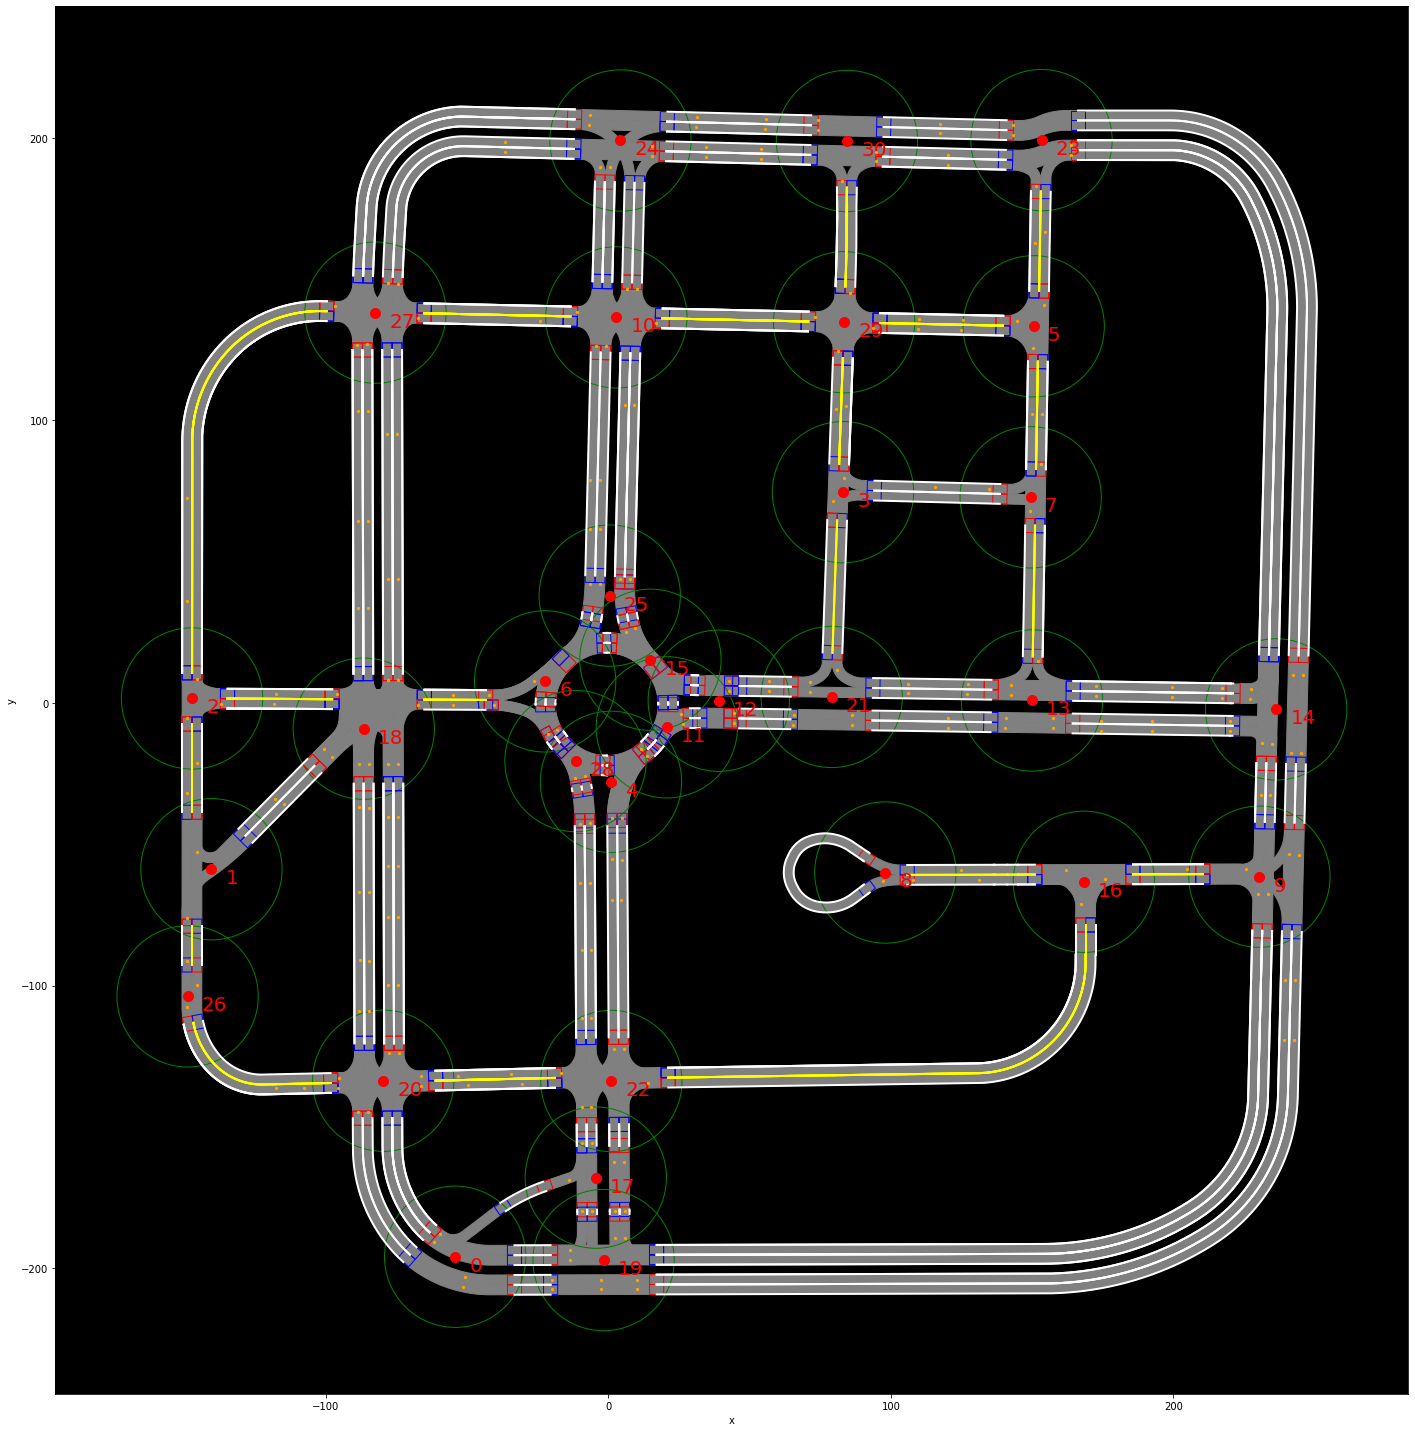

In [4]:
# Plot all the junctions and entrance/exits to/from the junctions
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax, map_data)

# Plot junction data
for idx, junction in enumerate(junctions):
    x, y = junction['pos']
    ax.plot(x, y, 'ro', markersize=10)
    ax.text(x + 5, y - 5, str(idx), color='r', size=20)
    circ = patches.Circle((x, y,), radius=25, color='g', fc='none')
    ax.add_patch(circ)
    for _wp1, _wp2 in junction['waypoints']:
        # entrances
        x, y, yaw, lane_width = _wp1
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='b', fc='none')
        ax.add_patch(bb)
        # exits
        x, y, yaw, lane_width = _wp2
        lw = np.array([5.0, lane_width])
        bbox = util.vertices_from_bbox(np.array([x, y]), yaw, lw)
        bb = patches.Polygon(bbox, closed=True, color='r', fc='none')
        ax.add_patch(bb)

ax.scatter(spawn_points.T[0], spawn_points.T[1], s=5, c='orange', zorder=10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

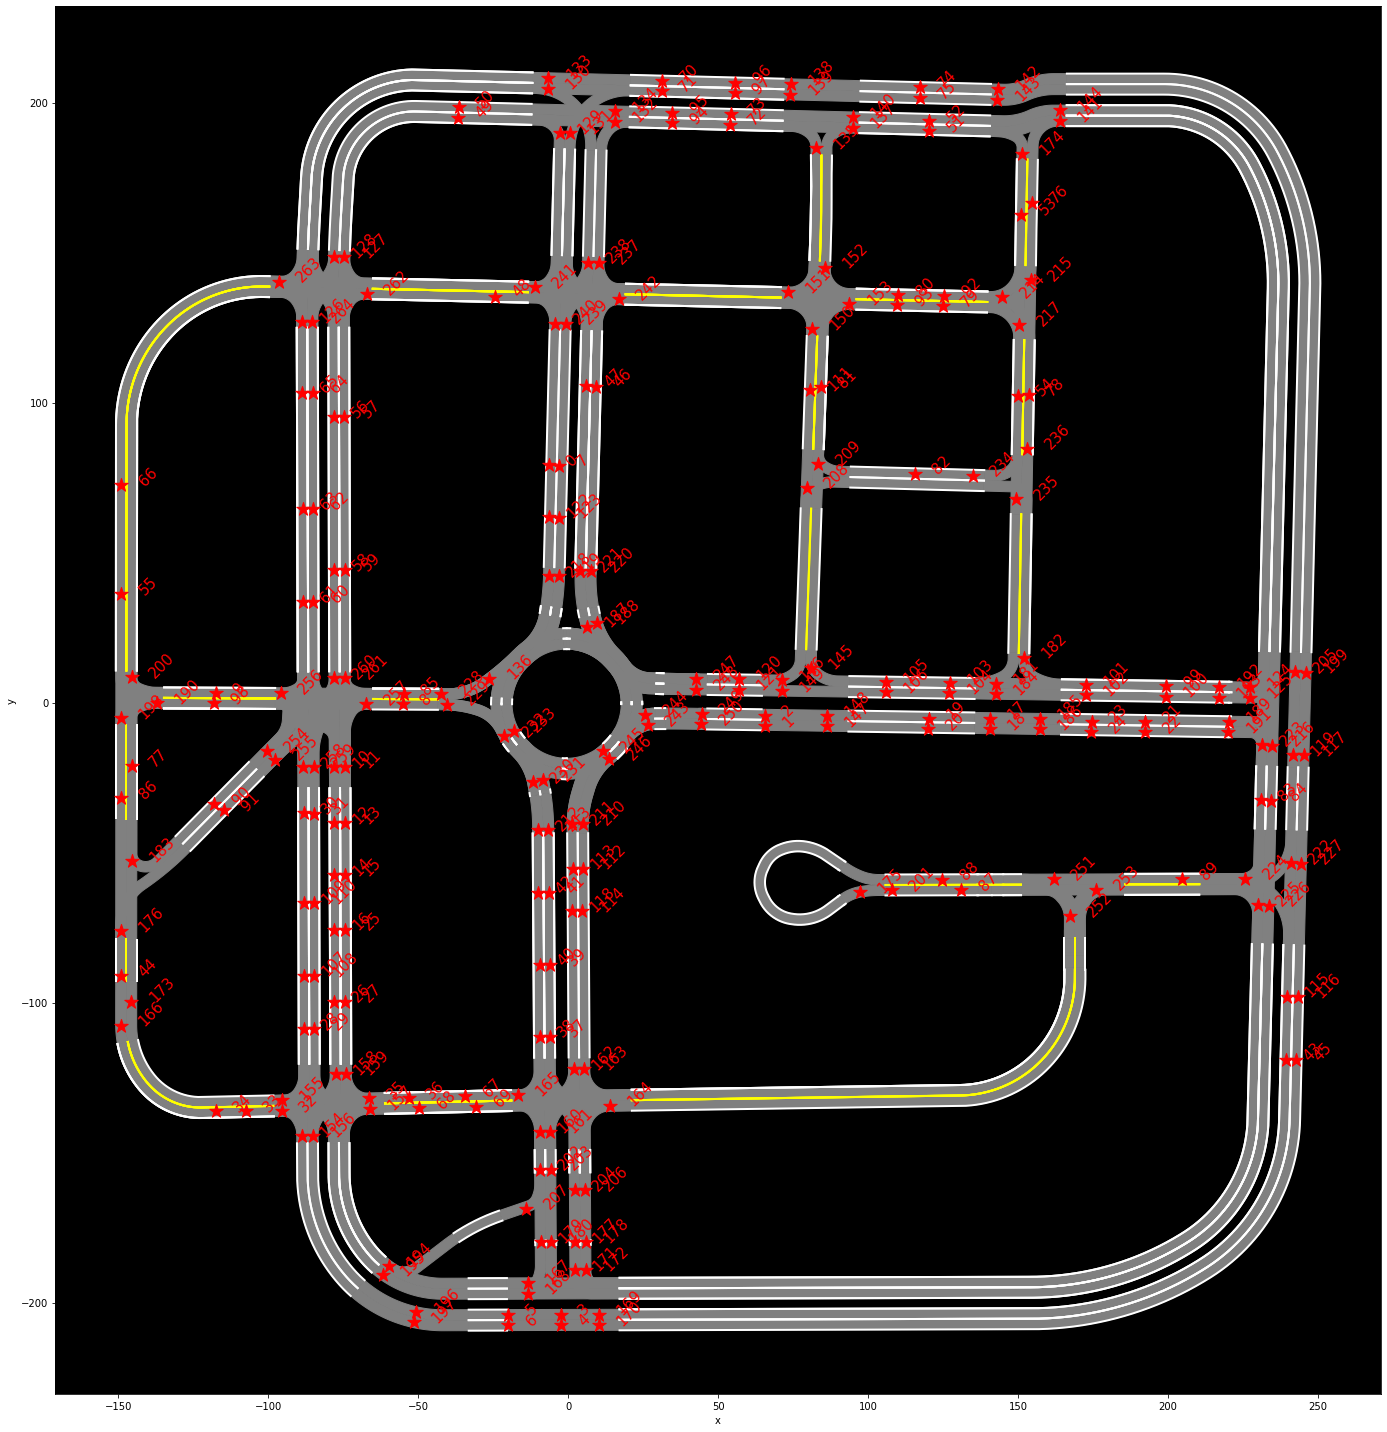

In [17]:
# there are 265 total possible spawn points
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax, map_data)

ax.scatter(spawn_points.T[0], spawn_points.T[1], marker='*', s=200, c='red', zorder=10)
for idx, point in enumerate(spawn_points):
    x, y, *_ = point
    plt.text(x + 5., y, str(idx), size=15, c='r', zorder=10, rotation=45)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

In [5]:
selected_points = [
    spawn_points[263, :3], # turn
    spawn_points[ 90, :3], # sharp T-intersection
    spawn_points[ 77, :3], # T-intersection
    spawn_points[115, :3], # large T-intersection
    spawn_points[247, :3], # roundabout outer
    spawn_points[248, :3], # roundabout inner
    spawn_points[ 85, :3], # multi-exit intersection
]
selected_points = np.stack(selected_points)

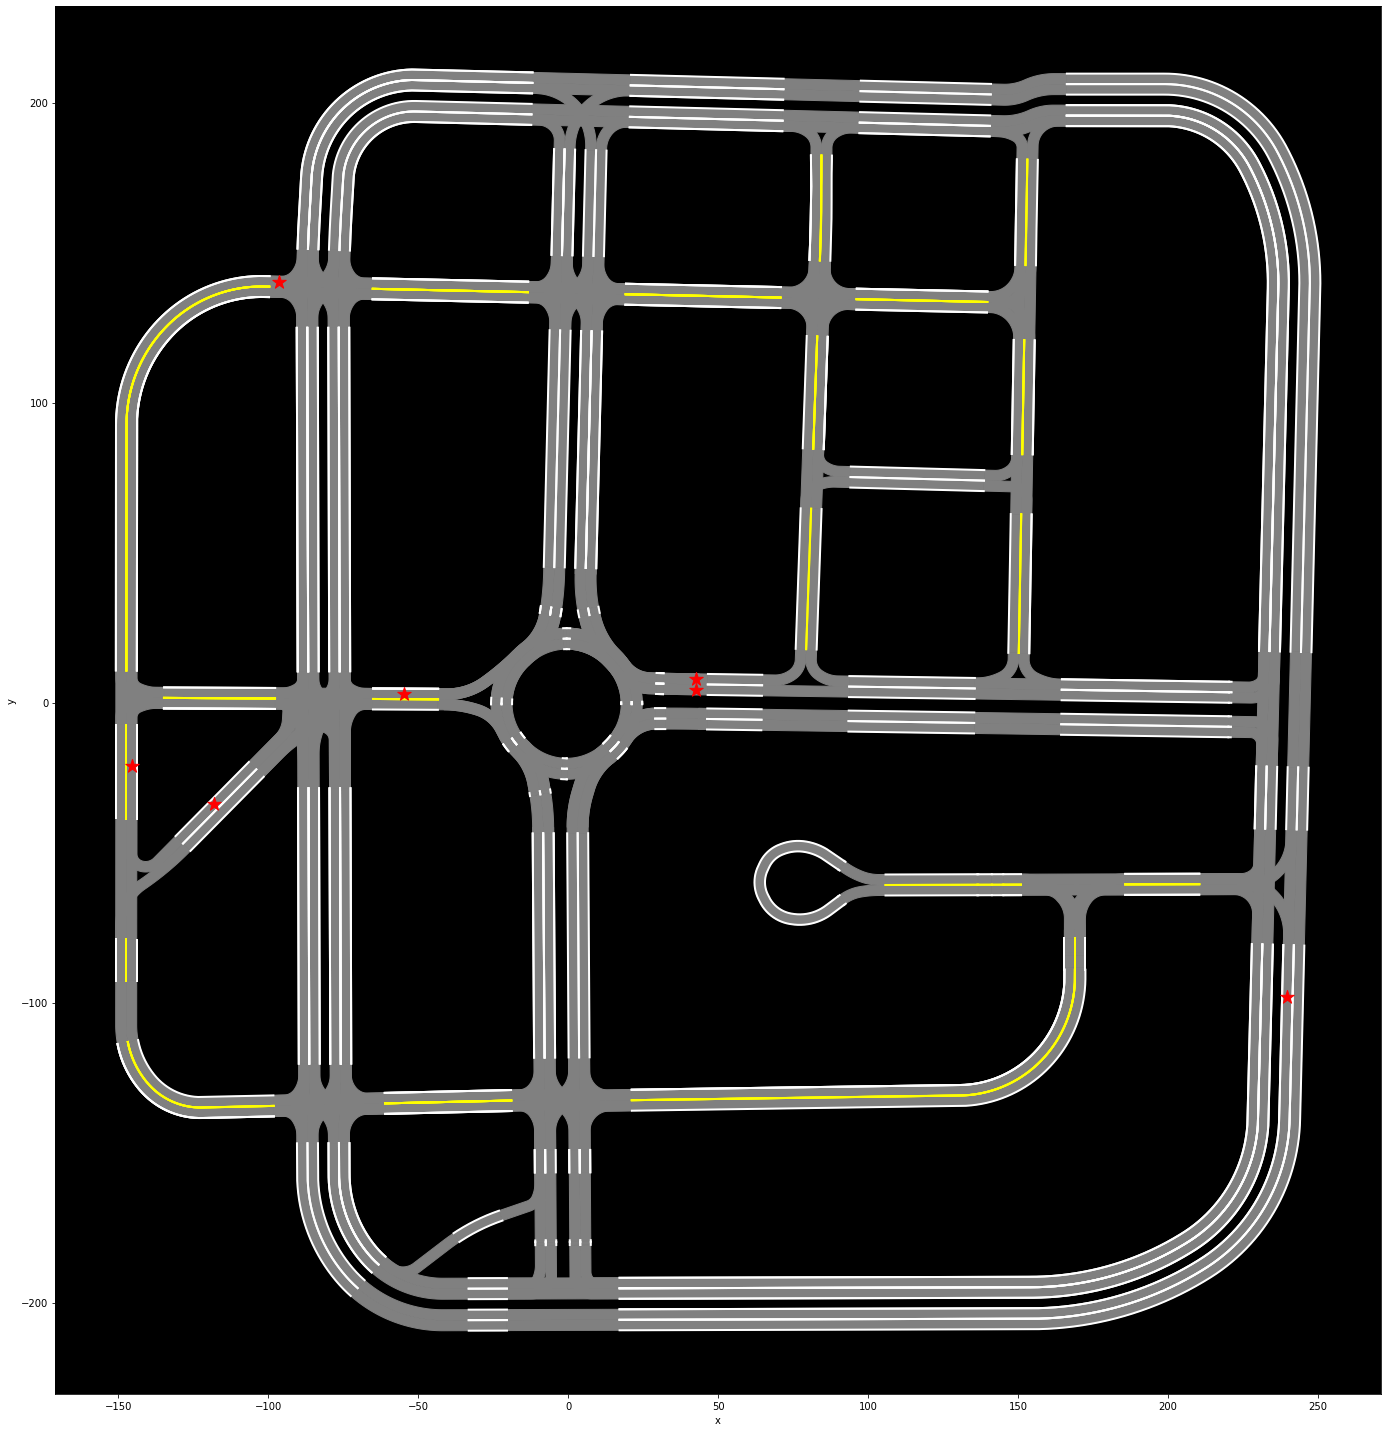

In [147]:
fig, ax = plt.subplots(figsize=(20,20))
render_entire_map(ax, map_data)
ax.scatter(selected_points.T[0], selected_points.T[1], marker='*', s=200, c='red', zorder=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

Selecting for specific points on the map. Needs CARLA server running.

In [37]:
client, world, carla_map = get_client_and_world_with("Town03")

In [38]:
PRECISION = 5.0

def to_point(wp):
    x, y, _ = carlautil.to_location_ndarray(wp, flip_y=True)
    return [x, y]

def compute_segment_length(delta, k):
    return 2*np.arccos(1/(k*delta + 1))/k

def _collect_points_along_waypoint(start_wp, choices, max_distance):
    # carla.Waypoint.next_until_lane_end() does not work very well
    # We are not using this
    wp = start_wp
    points = [to_point(wp)]
    lane_width = wp.lane_width
    cum_distance = 0.
    iidx = 0
    while True:
        wps = wp.next_until_lane_end(PRECISION)
        _points = util.map_to_list(to_point, wps)
        cum_distances = util.npu.cumulative_points_distances(
                    np.array([points[-1]] + _points))
        cum_distances += cum_distance
        if cum_distances[-1] > max_distance:
            idx = np.nonzero(cum_distances > max_distance)[0][0]
            points.extend(_points[:idx])
            return np.array(points)
        else:
            cum_distance = cum_distances[-1]
            points.extend(_points)
            next_wps = wps[-1].next(PRECISION)
            if len(next_wps) > 1:
                try:
                    wp = next_wps[choices[iidx]]
                except IndexError:
                    wp = next_wps[0]
                iidx += 1
            else:
                wp = next_wps[0]

def collect_points_along_waypoint(start_wp, choices, max_distance):
    wp = start_wp
    points = [to_point(wp)]
    cum_distance = 0.
    iidx = 0
    while cum_distance < max_distance:
        next_wps = wp.next(PRECISION)
        if len(next_wps) > 1:
            try:
                wp = next_wps[choices[iidx]]
            except IndexError:
                wp = next_wps[0]
            iidx += 1
        else:
            wp = next_wps[0]
        points.append(to_point(wp))
        x1, y1 = points[-2]
        x2, y2 = points[-1]
        cum_distance += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return np.array(points)
                
def cover_along_waypoints_fixedsize(start_wp, choices, max_distance, lane_width):
    """Cover 
    """
    points = collect_points_along_waypoint(start_wp, choices, max_distance)
#     to_delete = np.where(util.npu.consecutive_points_distances(points) < 3)[0]
#     points = np.delete(points, to_delete, axis=0)
    
    # fit a spline and get the 1st and 2nd spline derivatives
    distances = util.npu.cumulative_points_distances(points)
    distances = np.insert(distances, 0, 0)
    L = distances[-1]
    spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
    dspline = spline.derivative(1)
    ddspline = spline.derivative(2)

    # compute approx. max curvature
    distances = np.linspace(0, L, 10)
    max_k = np.max(np.linalg.norm(ddspline(distances), axis=1))

    # compute the vertices of road covers
    vertex_set = []
    half_lane_width = 0.55*lane_width
    segment_length = min(10, compute_segment_length(0.25, max_k))
    n = int(np.round(L / segment_length))
    distances = np.linspace(0, L, n)
    l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
    polytopes = []
    for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
        sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
        sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
        tangent1 = ddX1 / np.linalg.norm(ddX1)
        tangent2 = ddX2 / np.linalg.norm(ddX2)
        p1 = X1 + half_lane_width*sgn1*tangent1
        p2 = X2 + half_lane_width*sgn2*tangent2
        p3 = X2 - half_lane_width*sgn2*tangent2
        p4 = X1 - half_lane_width*sgn1*tangent1
        vertices = np.stack((p1, p2, p3, p4))
        A, b = util.npu.vertices_to_halfspace_representation(vertices)
        polytopes.append((A, b))
    return polytopes, max_k

## Manually make waypoints

max curvature is  0.022521422662428438


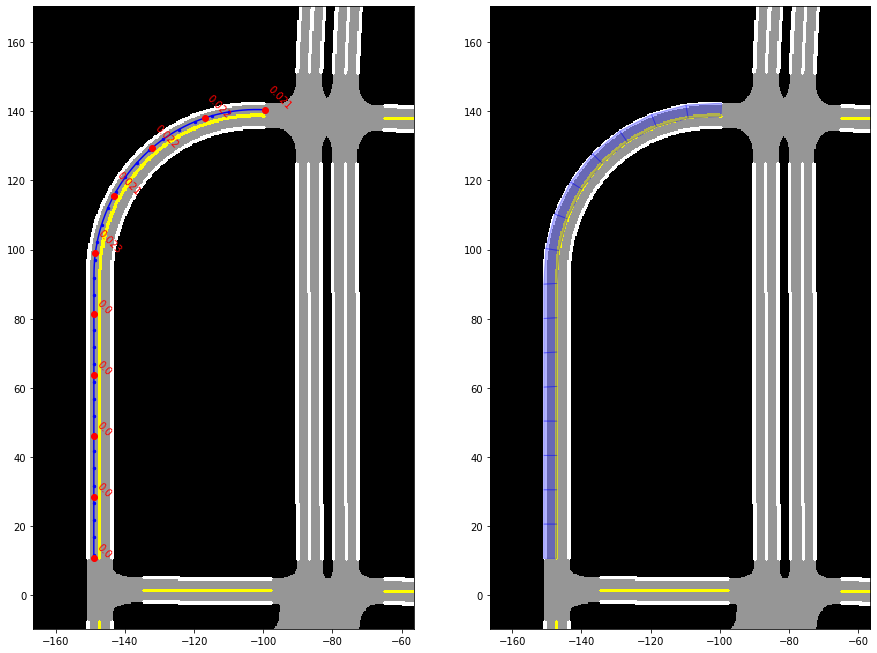

In [85]:
# Manually building road covers for a road turn

# plot the map overlay
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
x, y, z = selected_points[0][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 70, x + 40, y - 150, y + 30)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road road
points = []
x, y, z = selected_points[0][:3]
location = carla.Location(x, -y, z)

# get first set of waypoints
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
lane_width = wp.lane_width
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

# get second set of waypoints
wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

# collect set
points = np.concatenate(points)
axes[0].scatter(*points.T, s=6, c="b")

# fit a spline and get the 1st and 2nd spline derivatives
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# compute curvature at regularly spaced points
distances = np.linspace(0, L, 10)
axes[0].scatter(*spline(distances).T, c="r", zorder=10)
max_k = 0.
for s in distances:
    x, y = spline(s)
    k = np.linalg.norm(ddspline(s))
    max_k = k if max_k < k else max_k
    axes[0].text(x + 0.2, y + 0.2, f"{np.round(k, 3)}", color="r", rotation=-45, zorder=10)
print("max curvature is ", max_k)
    
# compute the vertices of road covers
vertex_set = []
half_lane_width = 0.55*lane_width
segment_length = compute_segment_length(0.25, max_k)
n = int(np.round(L / segment_length))
distances = np.linspace(0, L, n)
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    tangent1 = ddX1 / np.linalg.norm(ddX1)
    tangent2 = ddX2 / np.linalg.norm(ddX2)
    p1 = X1 + half_lane_width*sgn1*tangent1
    p2 = X2 + half_lane_width*sgn2*tangent2
    p3 = X2 - half_lane_width*sgn2*tangent2
    p4 = X1 - half_lane_width*sgn1*tangent1
    vertex_set.append(np.stack((p1, p2, p3, p4)))

# compute H-representation of road covers, plot
for vertices in vertex_set:
    A, b = util.npu.vertices_to_halfspace_representation(vertices)
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)

max curvature is  0.14907693664622929


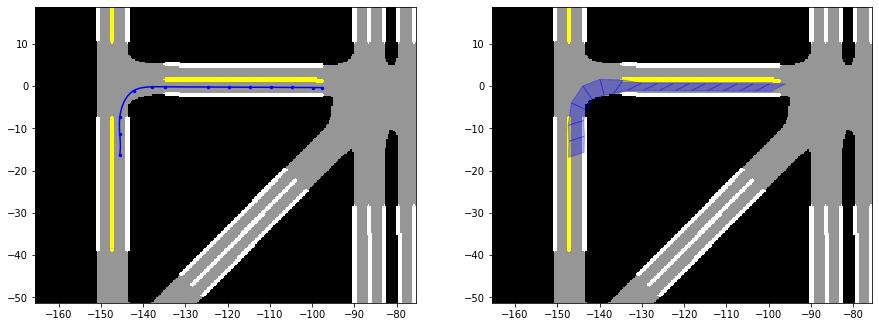

In [86]:

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[2][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 20, x + 70, y - 30, y + 40)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road road
points = []
x, y, z = selected_points[2][:3]
location = carla.Location(x, -y, z)

wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
lane_width = wp.lane_width
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[1] # get right turn waypoints
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

# collect set
points = np.concatenate(points)
axes[0].scatter(*points.T, s=6, c="b")

# fit a spline and get the 1st and 2nd spline derivatives
points

distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# compute max curvature
distances = np.linspace(0, L, 10)
max_k = np.max(np.linalg.norm(ddspline(distances), axis=1))
print("max curvature is ", max_k)

# compute the vertices of road covers
vertex_set = []
half_lane_width = 0.55*lane_width
segment_length = compute_segment_length(0.25, max_k)
n = int(np.round(L / segment_length))
distances = np.linspace(0, L, n)
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    tangent1 = ddX1 / np.linalg.norm(ddX1)
    tangent2 = ddX2 / np.linalg.norm(ddX2)
    p1 = X1 + half_lane_width*sgn1*tangent1
    p2 = X2 + half_lane_width*sgn2*tangent2
    p3 = X2 - half_lane_width*sgn2*tangent2
    p4 = X1 - half_lane_width*sgn1*tangent1
    vertex_set.append(np.stack((p1, p2, p3, p4)))

# compute H-representation of road covers, plot
for vertices in vertex_set:
    A, b = util.npu.vertices_to_halfspace_representation(vertices)
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)

max curvature is  0.22228896913603283


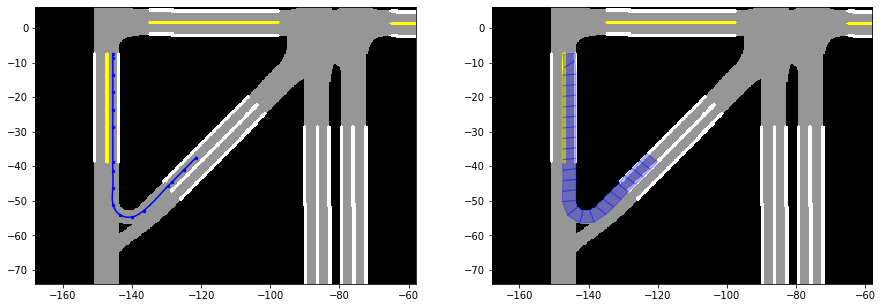

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[1][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 50, x + 60, y - 40, y + 40)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road road
points = []
x, y, z = selected_points[1][:3]
location = carla.Location(x, -y, z)

wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
lane_width = wp.lane_width
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

# collect set
points = np.concatenate(points)
axes[0].scatter(*points.T, s=6, c="b")

# fit a spline and get the 1st and 2nd spline derivatives
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# compute max curvature
distances = np.linspace(0, L, 10)
max_k = np.max(np.linalg.norm(ddspline(distances), axis=1))
print("max curvature is ", max_k)

# compute the vertices of road covers
vertex_set = []
half_lane_width = 0.55*lane_width
segment_length = compute_segment_length(0.25, max_k)
n = int(np.round(L / segment_length))
distances = np.linspace(0, L, n)
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    tangent1 = ddX1 / np.linalg.norm(ddX1)
    tangent2 = ddX2 / np.linalg.norm(ddX2)
    p1 = X1 + half_lane_width*sgn1*tangent1
    p2 = X2 + half_lane_width*sgn2*tangent2
    p3 = X2 - half_lane_width*sgn2*tangent2
    p4 = X1 - half_lane_width*sgn1*tangent1
    vertex_set.append(np.stack((p1, p2, p3, p4)))

# compute H-representation of road covers, plot
for vertices in vertex_set:
    A, b = util.npu.vertices_to_halfspace_representation(vertices)
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)

max curvature is  0.04607860613904909


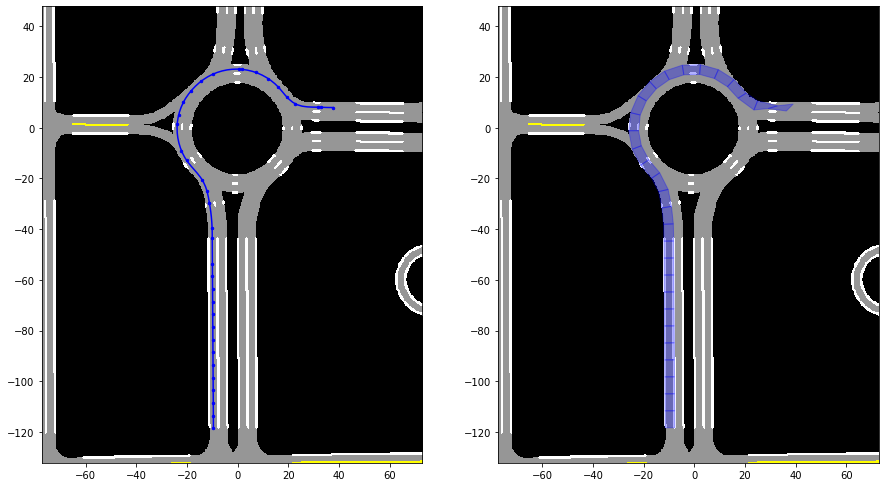

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[4][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 120, x + 30, y - 140, y + 40)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road road
points = []
x, y, z = selected_points[4][:3]
location = carla.Location(x, -y, z)

wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
lane_width = wp.lane_width
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0] # get left turn waypoints (out of 2)
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[1] #  get right turn waypoints (out of 2)
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

# collect set
points = np.concatenate(points)
axes[0].scatter(*points.T, s=6, c="b")

# fit a spline and get the 1st and 2nd spline derivatives
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# compute max curvature
distances = np.linspace(0, L, 10)
max_k = np.max(np.linalg.norm(ddspline(distances), axis=1))
print("max curvature is ", max_k)

# compute the vertices of road covers
vertex_set = []
half_lane_width = 0.55*lane_width
segment_length = compute_segment_length(0.25, max_k)
n = int(np.round(L / segment_length))
distances = np.linspace(0, L, n)
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    tangent1 = ddX1 / np.linalg.norm(ddX1)
    tangent2 = ddX2 / np.linalg.norm(ddX2)
    p1 = X1 + half_lane_width*sgn1*tangent1
    p2 = X2 + half_lane_width*sgn2*tangent2
    p3 = X2 - half_lane_width*sgn2*tangent2
    p4 = X1 - half_lane_width*sgn1*tangent1
    vertex_set.append(np.stack((p1, p2, p3, p4)))

# compute H-representation of road covers, plot
for vertices in vertex_set:
    A, b = util.npu.vertices_to_halfspace_representation(vertices)
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)

max curvature is  0.18863812447658967


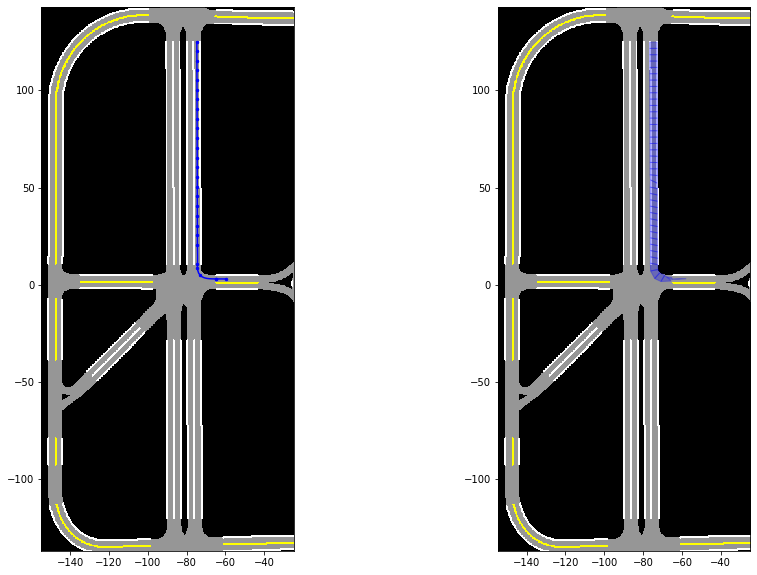

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[6][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 100, x + 30, y - 140, y + 140)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road road
points = []
x, y, z = selected_points[6][:3]
location = carla.Location(x, -y, z)

wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
lane_width = wp.lane_width
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[3] # get various turn waypoints (out of 4)
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

wp = wps[-1].next(PRECISION)[0]
wps = wp.next_until_lane_end(PRECISION)
points.append(np.array(util.map_to_ndarray(to_point, wps)))

# collect set
points = np.concatenate(points)
axes[0].scatter(*points.T, s=6, c="b")

# fit a spline and get the 1st and 2nd spline derivatives
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
dspline = spline.derivative(1)
ddspline = spline.derivative(2)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# compute max curvature
distances = np.linspace(0, L, 10)
max_k = np.max(np.linalg.norm(ddspline(distances), axis=1))
print("max curvature is ", max_k)

# compute the vertices of road covers
vertex_set = []
half_lane_width = 0.55*lane_width
segment_length = min(10, compute_segment_length(0.25, max_k))
n = int(np.round(L / segment_length))
distances = np.linspace(0, L, n)
l = util.pairwise(zip(spline(distances), dspline(distances), ddspline(distances)))
for (X1, dX1, ddX1), (X2, dX2, ddX2) in l:
    sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
    sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
    tangent1 = ddX1 / np.linalg.norm(ddX1)
    tangent2 = ddX2 / np.linalg.norm(ddX2)
    p1 = X1 + half_lane_width*sgn1*tangent1
    p2 = X2 + half_lane_width*sgn2*tangent2
    p3 = X2 - half_lane_width*sgn2*tangent2
    p4 = X1 - half_lane_width*sgn1*tangent1
    vertex_set.append(np.stack((p1, p2, p3, p4)))

# compute H-representation of road covers, plot
for vertices in vertex_set:
    A, b = util.npu.vertices_to_halfspace_representation(vertices)
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)

## Computationally make waypoints

max curvature 0.0657102397667586


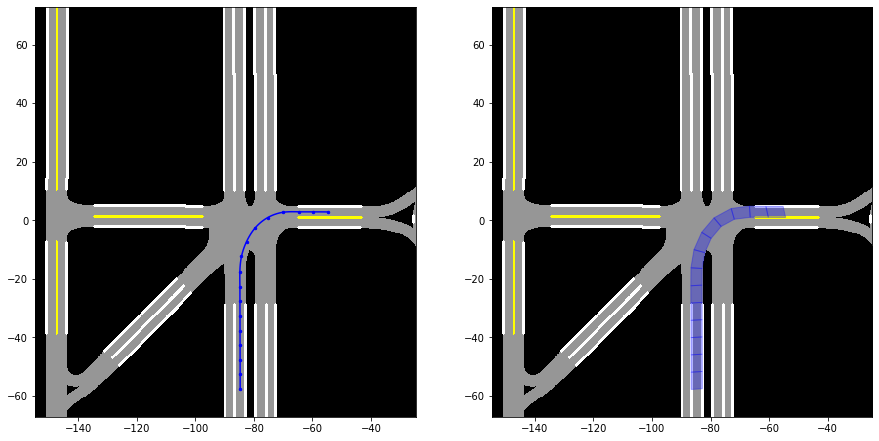

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[6][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 100, x + 30, y - 70, y + 70)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road
x, y, z = selected_points[6][:3]
location = carla.Location(x, -y, z)
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
choices, max_distance = [2], 80
points = collect_points_along_waypoint(wp, choices, max_distance)
axes[0].scatter(*points.T, s=6, c="b")

# fit spline on waypoint points
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# make covers for waypoints
lane_width = wp.lane_width
polytopes, max_k = cover_along_waypoints_fixedsize(wp, choices, max_distance, lane_width)
print("max curvature", max_k)
for A, b in polytopes:
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)


max curvature 0.05207964568737142


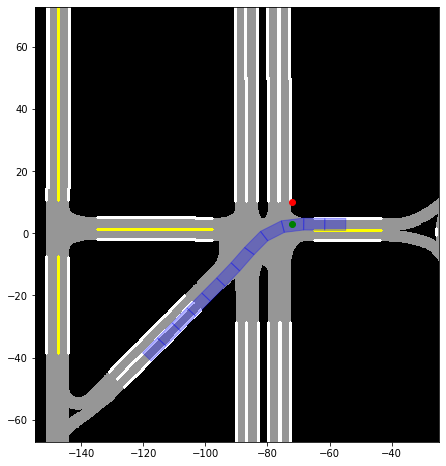

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
x, y, z = selected_points[6][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 100, x + 30, y - 70, y + 70)
render_map_crop(ax, map_data, extent)

lane_width = wp.lane_width
polytopes, max_k = cover_along_waypoints_fixedsize(wp, choices, max_distance, lane_width)
print("max curvature", max_k)
for A, b in polytopes:
    util.npu.plot_h_polyhedron(ax, A, b, fc='b', ec='b', alpha=0.3)

# check that containment queries using polytopes works
pt_1 = np.array([-72, 3])
pt_2 = np.array([-72, 10])
pt_clr = 'g' if np.any([np.all(A @ pt_1 <= b) for A, b in polytopes]) else 'r'
plt.scatter(*pt_1, c=pt_clr, zorder=10)
pt_clr = 'g' if np.any([np.all(A @ pt_2 <= b) for A, b in polytopes]) else 'r'
plt.scatter(*pt_2, c=pt_clr, zorder=10)

max curvature 0.06767098808054987


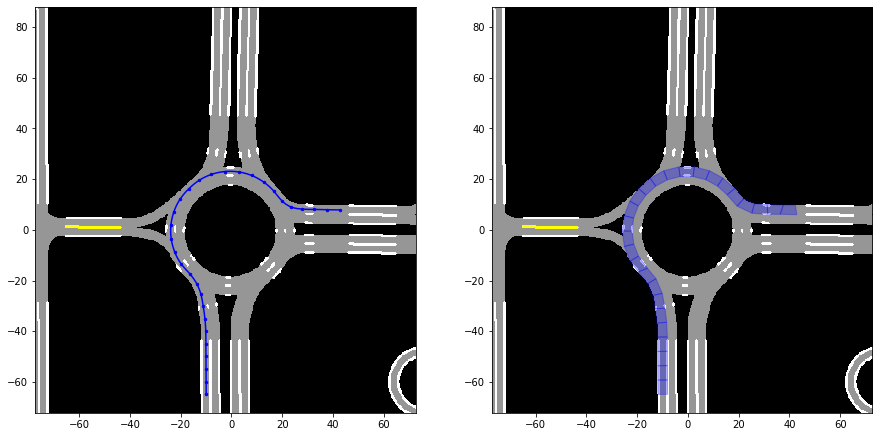

In [297]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[4][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 120, x + 30, y - 80, y + 80)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road
x, y, z = selected_points[4][:3]
location = carla.Location(x, -y, z)
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
choices, max_distance = [0, 1], 150
points = collect_points_along_waypoint(wp, choices, max_distance)
axes[0].scatter(*points.T, s=6, c="b")

# fit spline on waypoint points
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# make covers for waypoints
lane_width = wp.lane_width
polytopes, max_k = cover_along_waypoints_fixedsize(wp, choices, max_distance, lane_width)
print("max curvature", max_k)
for A, b in polytopes:
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)

max curvature 0.05572700282448158


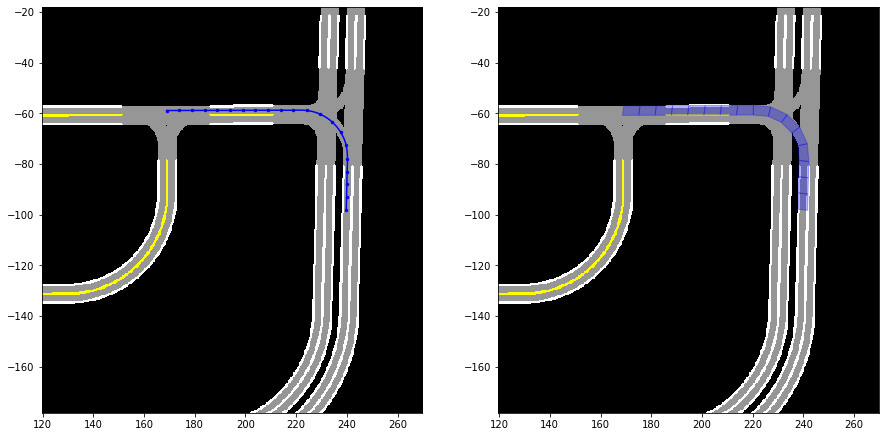

In [302]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = selected_points[3][:3]
# extent = (x_min, x_max, y_min, y_max)
extent = (x - 120, x + 30, y - 80, y + 80)
for ax in axes:
    render_map_crop(ax, map_data, extent)

# get the waypoint points from the road
x, y, z = selected_points[3][:3]
location = carla.Location(x, -y, z)
wp = carla_map.get_waypoint(location, project_to_road=True, lane_type=carla.LaneType.Driving)
choices, max_distance = [1, 0], 100
points = collect_points_along_waypoint(wp, choices, max_distance)
axes[0].scatter(*points.T, s=6, c="b")

# fit spline on waypoint points
distances = util.npu.cumulative_points_distances(points)
distances = np.insert(distances, 0, 0)
L = distances[-1]
spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
axes[0].plot(*spline(np.linspace(0, L, 100)).T, "-b")

# make covers for waypoints
lane_width = wp.lane_width
polytopes, max_k = cover_along_waypoints_fixedsize(wp, choices, max_distance, lane_width)
print("max curvature", max_k)
for A, b in polytopes:
    util.npu.plot_h_polyhedron(axes[1], A, b, fc='b', ec='b', alpha=0.3)